In [1]:
import polars as pl
import os
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")

In [3]:
df_sbs = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "side-by-side", "1_h_sbs_period_acropolis.parquet"))

In [ ]:
df_sbs.tail(5).collect()

system_id,sys_name_short,creation_timestamp,co2,h2o,ws,wd,OriginalFlag,Flag,picarro_corrected,diff,std,date
i64,str,"datetime[μs, UTC]",f32,f64,f64,f64,f64,str,f64,f64,f32,date
20,"""acropolis-20""",2024-02-11 19:00:00 UTC,442.492004,1.040245,null,null,0.0,null,442.12335,0.36859,1.610385,2024-02-11
20,"""acropolis-20""",2024-02-11 20:00:00 UTC,443.029572,1.039544,null,null,0.0,null,442.600645,0.428957,2.403531,2024-02-11
20,"""acropolis-20""",2024-02-11 21:00:00 UTC,441.950867,1.025521,null,null,0.0,null,441.351608,0.599303,2.093939,2024-02-11
20,"""acropolis-20""",2024-02-11 22:00:00 UTC,441.189758,1.007381,null,null,0.0,null,440.616843,0.57292,1.404987,2024-02-11
20,"""acropolis-20""",2024-02-11 23:00:00 UTC,437.22467,0.997951,null,null,0.0,null,437.743706,-0.518937,1.546635,2024-02-11


In [4]:
# plot daily mean per station

df_plot = df_sbs.sort("creation_timestamp") \
    .group_by([pl.col("date"), pl.col("sys_name_short")]) \
    .agg([
        (pl.col("diff").mean()).alias("daily_mean"),
        (pl.col("diff").median()).alias("daily_median")
        ]) \
    .collect()
    
fig = px.scatter(df_plot, x="date", y="daily_mean", color = "sys_name_short")
fig.show()
fig = px.scatter(df_plot, x="date", y="daily_median", color = "sys_name_short")
fig.show()

In [7]:
all_systems = []

system_list = df_sbs.collect()["system_id"].unique().to_list()

for id in system_list:
    print(f"processing {id}")
    
    #-------

    df_filtered = df_sbs \
        .filter(pl.col("picarro_corrected") > 0) \
        .filter(pl.col("co2") > 0) \
        .filter(pl.col("system_id") == id)  \
        .collect()
        
    df_filtered = df_filtered.with_columns([
            (np.abs(pl.col("picarro_corrected") - pl.col("co2"))).mean().alias("mae_full_deployment"),
            (np.square(np.subtract(pl.col("picarro_corrected"), pl.col("co2"))).mean()).alias("mse_full_deployment"),
                    ]) \
        .with_columns(pl.col("mse_full_deployment").sqrt().alias("rmse_full_deployment")) 
        
    all_systems.append(df_filtered)
    

processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20


In [9]:
df_all_sbs_filtered = pl.concat(all_systems, how="diagonal")
df_all_sbs_filtered.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "side-by-side", "1_h_sbs_rmse_acropolis.parquet"))

In [10]:
df_all_sbs_filtered = df_all_sbs_filtered.with_columns(pl.lit("Munich").alias("Mid-Cost Network"))

In [15]:
fig = px.scatter(df_all_sbs_filtered, x="creation_timestamp", y="diff", color = "sys_name_short")
fig.show()

In [17]:
fig = px.scatter(df_all_sbs_filtered, x="sys_name_short", y="mae_full_deployment")
fig.show()
fig = px.scatter(df_all_sbs_filtered, x="sys_name_short", y="rmse_full_deployment")
fig.show()

In [19]:
# 144 * 10 minute intervals in 1 day - 3 * 10 min intervals in one calibration
# 24* 1h interval in 1 day

df_plot = df_all_sbs_filtered.sort("creation_timestamp") \
    .group_by("sys_name_short") \
    .agg([(pl.col("co2").count() / 24).cast(int).alias("sbs_days"),
          pl.col("system_id"), pl.col("rmse_full_deployment").first()
          ]) \
    .with_columns((pl.col("sbs_days") > 14).alias("days_threshold")) \
    .sort("sbs_days")
    
fig = px.scatter(df_plot, x="sys_name_short", y="sbs_days", color="days_threshold")
fig.show()

In [20]:
fig = px.scatter(df_plot, x="sys_name_short", y="rmse_full_deployment", color = "sbs_days", color_continuous_scale=px.colors.sequential.Bluered_r)
fig.update_layout(
    yaxis_title='RMSE (ppm)',
    xaxis_title='System Identifier',
    title='',
)
fig.show()

In [22]:
df_plot = df_all_sbs_filtered.rename({"rmse_full_deployment":"RMSE (ppm)", "mae_full_deployment": "MAE (ppm)"}) \
    .join(df_plot, on="sys_name_short", how="left")
    
rmse_mean = df_plot["RMSE (ppm)"].unique().mean()
print(rmse_mean)

1.0104798485731101


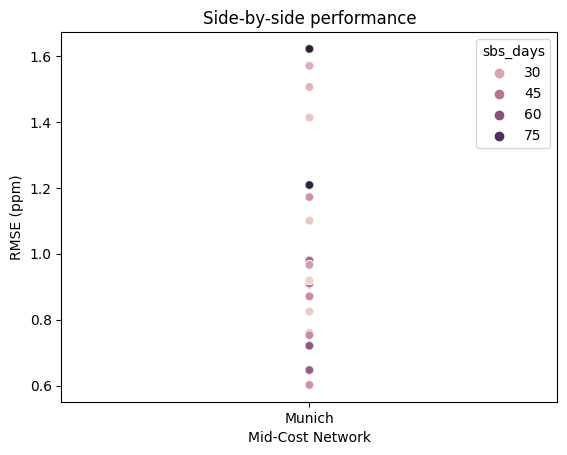

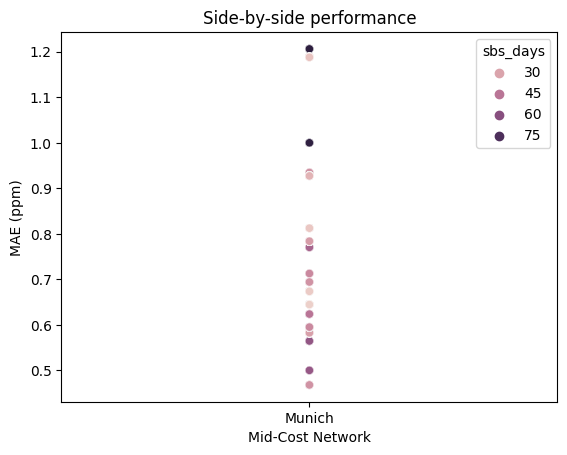

In [23]:
sns.scatterplot(data=df_plot,x='Mid-Cost Network',y='RMSE (ppm)', hue="sbs_days", alpha=0.5).set(title='Side-by-side performance')
plt.show()

sns.scatterplot(data=df_plot,x='Mid-Cost Network',y='MAE (ppm)', hue="sbs_days", alpha=0.5).set(title='Side-by-side performance')
plt.show()